In [1]:
import pandas as pd
import numpy as np
import re, string

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('fivethirtyeight')

In [3]:
data = pd.read_csv('train_cv_target.csv')

## Create Features

In [4]:
def boxcox_feature(feature_name, df):
    import scipy.stats as spstats
    feature_np = np.array(data[feature_name])
    feature_np_clean = feature_np[~np.isnan(feature_np)]
    l, opt_lambda = spstats.boxcox(feature_np_clean)
    df[feature_name+'_0'] = spstats.boxcox(
                                        (1+df[feature_name]), 
                                          lmbda=0)
    df[feature_name+'_0'] = df[feature_name+'_0'].fillna(0.0)
    df[feature_name+'_boxcox_lambda_opt'] = spstats.boxcox(
                                            df[feature_name], lmbda = opt_lambda)
    df[feature_name+'_boxcox_lambda_opt'] = df[feature_name+'_boxcox_lambda_opt'].fillna(0.0)
    return df

In [5]:
 #just feed df with eng columns
def transfrom_numerical(df):
    features_numerical = ['GuaranteeValueLot', 'StepDecreaseLot', 'SumTender']
    for feature in features_numerical:
        df[feature] = df[feature].apply(pd.to_numeric, errors='coerce')
    df[features_numerical] = df[features_numerical].fillna(0)
    for feature in features_numerical:
        df[feature+'_isZero'] = df[feature].apply(lambda x: 1 if x==0.0 else 0)
    df[features_numerical] = df[features_numerical].replace(0.0, np.nan)
    for feature in features_numerical:
        df = boxcox_feature(feature, df)
    df = df.drop(columns=features_numerical)
    return df

In [7]:
def strip(x, n):
    return x.strip()[:n].strip()

def add_CPV_features(df, split_type=1):
    df['CPV2017'] = df['CPV2017'].apply(lambda x: '00000000-0' if strip(x, 10) == '-' else x)
    
    if split_type == 1:
        df['CPV_unit'] = df['CPV2017'].apply(lambda x: x.strip()[:2])
        df['CPV_group'] = df['CPV2017'].apply(lambda x: x.strip()[2:3])
        df['CPV_class'] = df['CPV2017'].apply(lambda x: x.strip()[3:4])
        df['CPV_cat'] = df['CPV2017'].apply(lambda x: x.strip()[4:5])
    else:
        df['CPV_unit'] = df['CPV2017'].apply(lambda x: x.strip()[:2])
        df['CPV_group'] = df['CPV2017'].apply(lambda x: x.strip()[:3])
        df['CPV_class'] = df['CPV2017'].apply(lambda x: x.strip()[:4])
        df['CPV_cat'] = df['CPV2017'].apply(lambda x: x.strip()[:5])
    
    df['CPV_desc'] = df['CPV2017'].apply(lambda x: x[11:])
    df['CPV_desc'] = df['CPV_desc'].apply(lambda x: "NO DESC" if len(x.strip()) < 2 else x )
    
    df['Organizer'] = df['Organizer'].apply(lambda x: x.lower())
    df['Organizer_railroad'] = df['Organizer'].apply(lambda x: 1 if 'залізниц' in x else 0)
    df['Organizer_ministry'] = df['Organizer'].apply(lambda x: 1 if 'міністерств' in x else 0)
    df['Organizer_komun'] = df['Organizer'].apply(lambda x: 1 if 'комунальне підприємство' 
                                                  in x else 0)
    df['Organizer_edu'] = df['Organizer'].apply(lambda x: 1 if 'освіт' in x else 0)
    
    return df

In [8]:
data = transfrom_numerical(data)

/Users/jenya/miniconda3/lib/python3.5/site-packages/scipy/stats/morestats.py:1030: RuntimeWarning: invalid value encountered in less_equal
  if any(x <= 0):


In [9]:
data = add_CPV_features(data)

In [10]:
train = data[data.train_val=='train']
val = data[data.train_val=='val']

In [11]:
def rmsle(y_true,y_pred):
    assert len(y_true) == len(y_pred)
    return np.square(np.log(y_pred + 1) - np.log(y_true + 1)).mean() ** 0.5

same for `Oganizer` = **0.37331**

---

---

In [12]:
import tokenize_uk

In [33]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier, LinearRegression, SGDR
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

In [14]:
def preprocess(text):
    return ' '.join(tokenize_uk.tokenize_words(text)).lower()

In [27]:
train['text_prep'] = train['LotDescr'].map(preprocess) 

/Users/jenya/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [28]:
val['text_prep'] = val['LotDescr'].map(preprocess) 

/Users/jenya/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [52]:
logistic_tfidf_base = Pipeline([
    ("tfidf_vectorizer", TfidfVectorizer(ngram_range=(1, 1), min_df=10, max_features=5000)),
    ("lr", LinearRegression()) # linear is better
])

ridge_tfidf_base = Pipeline([
    ("tfidf_vectorizer", TfidfVectorizer(ngram_range=(1, 1), min_df=10, max_features=5000)),
    ("lr", Ridge(solver='auto', fit_intercept=True, alpha=0.4, max_iter=250, normalize=False, tol=0.01)) # linear is better
])

In [53]:
model = ridge_tfidf_base

In [54]:
model.fit(train['text_prep'], train['counts'])

Pipeline(memory=None,
     steps=[('tfidf_vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=5000, min_df=10,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth... fit_intercept=True, max_iter=250,
   normalize=False, random_state=None, solver='auto', tol=0.01))])

In [55]:
predicitons = model.predict(val['text_prep'])

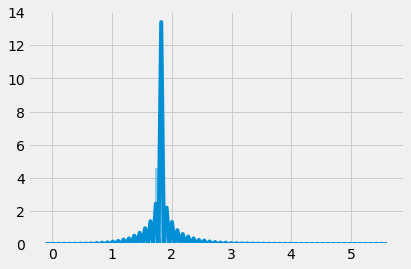

In [56]:
sns.distplot(predicitons)

In [57]:
rmsle(val['counts'], predicitons)

0.3675774452701687

In [38]:
rmsle(val['counts'], predicitons)

0.3675031600913592

In [ ]:
rmsle(val['counts'], predicitons)

In [22]:
rmsle(val['counts'], predicitons)

0.3622927869838578

In [140]:
rmsle(val['counts'], predicitons)

0.3621992066878041

In [40]:
import eli5

In [41]:
eli5.explain_weights(model)

Explanation(estimator="Pipeline(memory=None,\n     steps=[('tfidf_vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',\n        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n        lowercase=True, max_df=1.0, max_features=5000, min_df=10,\n        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth... fit_intercept=True, max_iter=250,\n   normalize=False, random_state=None, solver='auto', tol=0.01))])", description="\nFeatures with largest coefficients.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='уповноваженими', weight=7.398444731198435, std=None, value=None), FeatureWeight(feature='трубопроводiв', weight=3.957966309008753, std=None, value=None), FeatureWeight(feature='супроводжується', weight=3.559668139218911, std=None, value=None), FeatureWeight(feature='параметрам', weight=3.329216501508384, std=None, value=None), FeatureWeight(feature='прийнято', weight=3.2538630906648107, std=None, value=None), FeatureWeight(feature='сєдова', weight=3.220318637764574, std=None, value=None), FeatureWeight(feature='е27', weight=3.1818749301337026, std=None, value=None), FeatureWeight(feature='десяти', weight=3.1308093671652366, std=None, value=None), FeatureWeight(feature='стороннього', weight=3.124750164935455, std=None, value=None), FeatureWeight(feature='резинці', weight=2.79732849553406, std=None, value=None), FeatureWeight(feature='веб', weight=2.6373509919186002, std=None, value=None), FeatureWeight(feature='гкр', weight=2.6035587905840014, std=None, value=None), FeatureWeight(feature='переговорної', weight=2.5914784607306647, std=None, value=None)], neg=[FeatureWeight(feature='оріхівске', weight=-3.4966985008492832, std=None, value=None), FeatureWeight(feature='кисломолочниий', weight=-3.3291900646121366, std=None, value=None), FeatureWeight(feature='метрологічними', weight=-3.075832528650426, std=None, value=None), FeatureWeight(feature='язань', weight=-2.98967151229041, std=None, value=None), FeatureWeight(feature='дiаметром', weight=-2.895793906589424, std=None, value=None), FeatureWeight(feature='sunpp', weight=-2.7633916491043915, std=None, value=None), FeatureWeight(feature='така', weight=-2.59536428076181, std=None, value=None)], pos_remaining=2280, neg_remaining=2701), proba=None, score=None, weighted_spans=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None)

In [130]:
text = """
    Державне підприємство "Національний академічний театр  драми імені Лесі Українки"
"""

In [131]:
eli5.explain_prediction_sklearn(
    model.steps[1][1],
    preprocess(text),
    vec=model.steps[0][1],
    feature_names=model.steps[0][1].get_feature_names(), )

Explanation(estimator='LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)', description=None, error=None, method='linear model', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=1.837034664226061, std=None, value=1.0), FeatureWeight(feature='академічний', weight=0.32909695131009903, std=None, value=0.3374431340925673), FeatureWeight(feature='державне', weight=0.12816819840642368, std=None, value=0.24555118453253133), FeatureWeight(feature='імені', weight=0.1253523147806536, std=None, value=0.26567095498514565), FeatureWeight(feature='національний', weight=0.10373609554907709, std=None, value=0.26475960791123615)], neg=[FeatureWeight(feature='драми', weight=-3.9846278496531067, std=None, value=0.43825077149490177), FeatureWeight(feature='театр', weight=-0.6726081991395995, std=None, value=0.33632119397846894), FeatureWeight(feature='українки', weight=-0.48467866324227094, std=None, value=0.4196954917703963), FeatureWeight(feature='підприємство', weight=-0.09864811231395863, std=None, value=0.16605574989288288), FeatureWeight(feature='лесі', weight=-0.046619398489955395, std=None, value=0.41983751452742224)], pos_remaining=0, neg_remaining=0), proba=None, score=-2.7637939985665767, weighted_spans=WeightedSpans(docs_weighted_spans=[DocWeightedSpans(document='державне підприємство " національний академічний театр драми імені лесі українки "', spans=[('державне', [(0, 8)], 0.12816819840642368), ('підприємство', [(9, 21)], -0.09864811231395863), ('національний', [(24, 36)], 0.10373609554907709), ('академічний', [(37, 48)], 0.32909695131009903), ('театр', [(49, 54)], -0.6726081991395995), ('драми', [(55, 60)], -3.9846278496531067), ('імені', [(61, 66)], 0.1253523147806536), ('лесі', [(67, 71)], -0.046619398489955395), ('українки', [(72, 80)], -0.48467866324227094)], preserve_density=False, vec_name=None)], other=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=1.837034664226061, std=None, value=1.0)], neg=[FeatureWeight(feature=<FormattedFeatureName 'Highlighted in text (sum)'>, weight=-4.6008286627926385, std=None, value=None)], pos_remaining=0, neg_remaining=0)))], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None)

In [123]:
eli5.explain_prediction(logistic_tfidf_base, text)

Explanation(estimator="Pipeline(memory=None,\n     steps=[('tfidf_vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',\n        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n        lowercase=True, max_df=1.0, max_features=None, min_df=10,\n        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth...bulary=None)), ('lr', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])", description=None, error="estimator Pipeline(memory=None,\n     steps=[('tfidf_vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',\n        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n        lowercase=True, max_df=1.0, max_features=None, min_df=10,\n        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth...bulary=None)), ('lr', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))]) is not supported", method=None, is_regression=False, targets=None, feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None)

In [120]:
train[train['text_prep'].str.contains('російської')].iloc[0]['Organizer']

'Державне підприємство "Національний академічний театр російської драми імені Лесі Українки"'